Task 1: Data Filtering

In [5]:
%pip install "dask[dataframe]" pandas langdetect

# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 10.1 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 12.4 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 14.5 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.8 MB 13.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 13.7 MB/s  0:00:01
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading data from ../../data/filtered_reviews.csv...
Loaded 193166 reviews.
Starting text preprocessing
Preprocessing complete!
Generating Word Cloud...


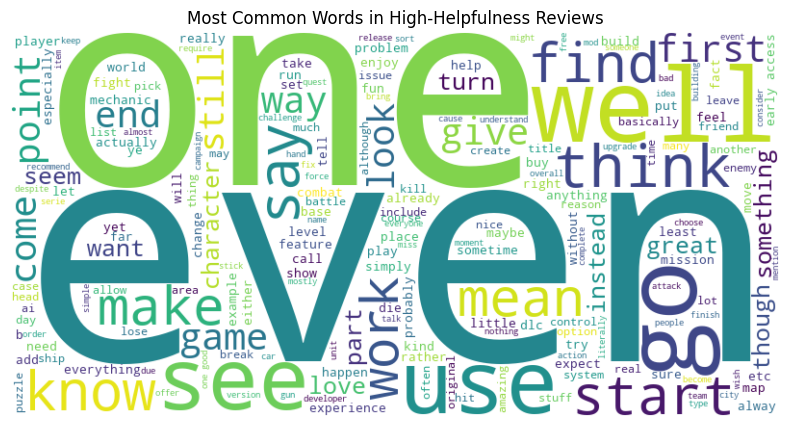

Generating Frequency Plot...


C:\Users\abdul\AppData\Local\Temp\ipykernel_20916\1309111541.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


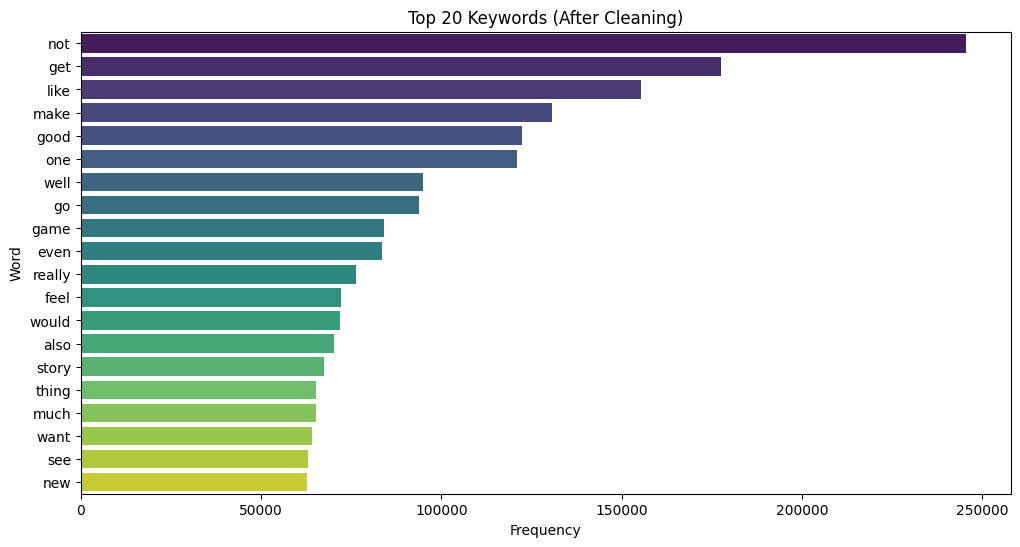

Generating Correlation Heatmap...


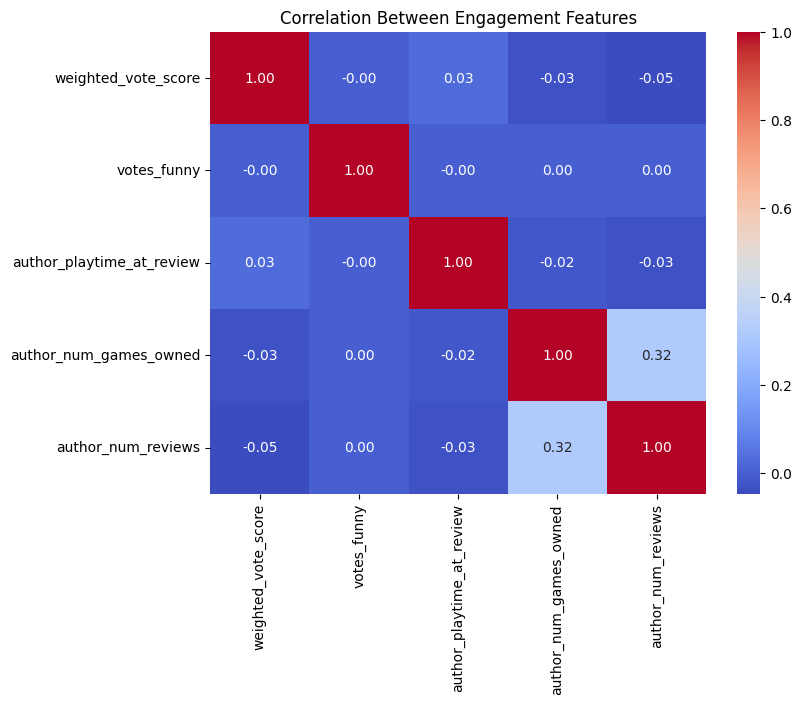

Logistic Regression:
Accuracy: 0.8100119066107574
Precision: 0.8100119066107574
Recall: 1.0
F1 Score: 0.8950348930328338

Decision Tree:
Accuracy: 0.709504581456748
Precision: 0.8276897959183673
Recall: 0.8099955262989711
F1 Score: 0.8187470727886432


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

print("Starting text preprocessing")

# Apply the function to the 'review' column
# df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")

# Save Output
# Save the dataset with the new 'cleaned_review' column
# df.to_csv(OUTPUT_FILE, index=False)
# print(f"Saved processed data to {OUTPUT_FILE}")

df = pd.read_csv(OUTPUT_FILE)
df['cleaned_review'] = df['cleaned_review'].fillna('')

# 3. Word Cloud
print("Generating Word Cloud...")
all_text = " ".join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in High-Helpfulness Reviews')
plt.show()

# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()



features = ['author_playtime_at_review', 'author_num_games_owned', 'author_num_reviews', 'votes_funny', 'weighted_vote_score']

target = 'voted_up'
df[target] = df[target].astype(int)

X = df[features]
y = df[target]

# imputer to handle missing data
imp = SimpleImputer(strategy='mean')
X_imp = imp.fit_transform(X)

# scale data for logistical regression
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_imp)

# train data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=0)

# initialize the simple models
logmodel = LogisticRegression(random_state=0)
decisiontree = DecisionTreeClassifier(random_state=0)

# train models
logmodel.fit(X_train, y_train)
y_pred_log = logmodel.predict(X_test)
decisiontree.fit(X_train, y_train)
y_pred_dt = decisiontree.predict(X_test)

# display results
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")
print(f"Precision: {precision_score(y_test, y_pred_log)}")
print(f"Recall: {recall_score(y_test, y_pred_log)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log)}")
print("")
print("Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt)}")


# the more advanced models
X_adv = df[numeric_features] + ['cleaned_review']
y_adv = df['voted_up']

